# Analysis of Model Selection measures

datasets=("urchininf/base_strongaug_ema_inf_sq" "urchininf/aldi_inf_sq" "urchininf/mt_inf_sq" "urchininf/oracle_strongaug_ema_sq" "urchininf/base_strongaug_ema_inf_udd" "urchininf/aldi_inf_udd" "urchininf/mt_inf_udd" "urchininf/oracle_strongaug_ema_udd")


In [62]:
import glob
import os
import pandas as pd
import json
import numpy as np
from skimage.segmentation import disk_level_set

print(os.getcwd())
paths = glob.glob('../outputs/*/*/UMS*dict_output.json') + glob.glob('../outputs/*/*/DAS*dict_output.json')
paths = (glob.glob('../saga_outputs/outputs/urchininf/*base*/UMS*dict_output.json') 
         + glob.glob('../saga_outputs/outputs/urchininf/*base*/DAS*dict_output.json') 
         + glob.glob('../outputs/urchininf/*base*/BoS*dict_output.json'))

/home/heather/GitHub/aldi0107/dev_stuff


In [63]:
import os
import json
from collections import defaultdict


def get_measure_name(output_filename):
    return os.path.basename(output_filename).split('_dict_output')[0]



path_dict = defaultdict(list)

for p in paths:
    base_path, result_file = os.path.split(p)
    split_path = base_path.split('/')
    domain = split_path[-2]
    method = split_path[-1]
    path_dict[(domain, method)].append(p)
    

In [64]:
result_fields = {'UMS': ['gt/bbox/AP', 'gt/bbox/AP50', 
                         'umsdas/iou', 'umsdas/giou', 'umsdas/ioukl', 'umsdas/ioukl_iou', 'umsdas/ioukl_kl', 'umsdas/info_max_reg', 'umsdas/entropy', 'umsdas/kldiv', 
                         'ums_5/iou', 'ums_5/giou', 'ums_5/ioukl', 'ums_5/ioukl_iou', 'ums_5/ioukl_kl', 'ums_5/kldiv',
                         ],
                         #'umsdropout/iou', 'umsdropout/giou', 'umsdropout/ioukl', 'umsdropout/ioukl_iou', 'umsdropout/ioukl_kl', 'umsdropout/kldiv'],
                'BoS': ['BoS'],
                'DAS': ['DAS',  'PDR_normalized', 'FIS_normalized'],
                 }

result_fields = {
                'UMS': ['gt/bbox/AP50', # 'gt/bbox/AP', 
                         'umsdas/ioukl', 'umsdas/info_max_reg', 'umsdas/entropy', 
                          #'umsdas/iou', 'ums_5/ioukl',  'ums_5/kldiv',
                         #'ums_5/iou', 'ums_5/giou', 'ums_5/ioukl', 'ums_5/ioukl_iou', 'ums_5/ioukl_kl', 'ums_5/kldiv',
                         ],
                'BoS': ['BoS'],
                'DAS': ['DAS', 'PDR_normalized', 'FIS_normalized'],
                 }

rows = []
for (domain, method), result_files in path_dict.items():
    split_path = base_path.split('/')
    datas = {}
    for result_file in result_files:
        with open(result_file, 'r') as file:
            data = json.load(file)
        measure = get_measure_name(os.path.split(result_file)[1])
        if measure not in ['DAS']:
            data = {os.path.basename(k): results for k, results in data.items()}
        datas[measure] = data
    models = datas['UMS'].keys() if 'UMS' in datas else []
    for m in models:
        iterations = int(m[-11:-4])
        row = [domain,method, m, iterations]
        for measure, fields in result_fields.items():
            measure_data = datas.get(measure, None)
            if measure_data is None:
                for f in fields:
                    row.append(np.nan)
                print(f"No data for {measure} {domain} {method} {m}")
            else:
                model_measure_data = measure_data.get(m, None)
                if model_measure_data is not None:
                    datasets = [k for k in datas[measure].get(m, None).keys() if '_val' in k or 'test' in k]
                    if len(datasets)!= 1:
                        print(f"Can't get val dataset: {row} {measure} {m} {datasets}")
                    results = datas[measure][m][datasets[0]]
                    if 'umsdropout' in results.keys():
                        results['ums_5'] = results['umsdropout']
                        del results['umsdropout']
                for f in [field for field in fields if 'umsdropout' not in field]:
                    if model_measure_data is not None:
                        keys = f.split("/")
                        result = results
                        for k in keys:
                            result = result.get(k, None) if result is not None else None
                        if result is None:
                            result = np.nan
                        elif type(result) is list:
                            result = result[0]
                        elif result is None:
                            result = np.nan
                        elif type(result) is dict:
                            result = result['1'][0] # FIS storage
                        row.append(result)
                    else:
                        row.append(np.nan)
        rows.append(row)
headings = ['domain', 'method', 'model', 'iters']
for measure, fields in result_fields.items():
    for f in fields:
        if "AP50" in f:
            h = "AP50"
        elif "AP" in f:
            h = "AP"
        else:
            h = f"{measure}_{f}"
        if 'umsdropout' not in h:
            headings.append(h)

df = pd.DataFrame(data=rows, columns=headings)

#df['UMS_sum'] = df['UMS_entropy'] + df['UMS_info_max_reg']
#df['UMS_diff'] = - df['UMS_entropy'] + df['UMS_info_max_reg']
#df['UMS_comb'] =df['UMS_loss_box_giou'] - df['UMS_loss_score_logits']


In [65]:
def y_axis_title(column):
    column_lookup = {
        "DAS_DAS": "DAS",
        "DAS_PDR_normalized": "PDR",
        "DAS_FIS_normalized": "FIS",
        "BoS_BoS": "BoS",
        "UMS_umsdas/ioukl": "Our UMS metric",
    }
    col_name = column_lookup.get(column, None)
    if col_name is not None:
        return col_name
    else:
        split = column.split("/")
        if split[-1] == 'entropy':
            return "Entropy"
        if split[-1] == "info_max_reg":
            return "Info Max Reg"
        perturb_split = split[0].split("_")
        if perturb_split[0] =="UMS":
            if perturb_split[-1] == 'umsdas':
                perturb = "Perturb"
            else:
                perturb = f"Dropout({perturb_split[-1]})"
            return f"{split[-1]} ({perturb})"
        else:
            return column
    

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_axis_lookup = {}

vals = sorted([h for h in headings[4:] if h not in ["AP50", "AP"]]) 
baseline = "AP50"
import matplotlib.pyplot as plt
import pandas as pd

methods = sorted(list(set(df['method'])))
methods = [m for m in methods if 'strongaug' in m] + [m for m in methods if 'aldi' in m.lower()]

method_title_dictionary = {
    'base_strongaug_ema_inf_sq': "Base Model - Infinigen->IMOS AUV",
    'base_strongaug_ema_inf_udd': "Base Model - Infinigen->UDD",
}

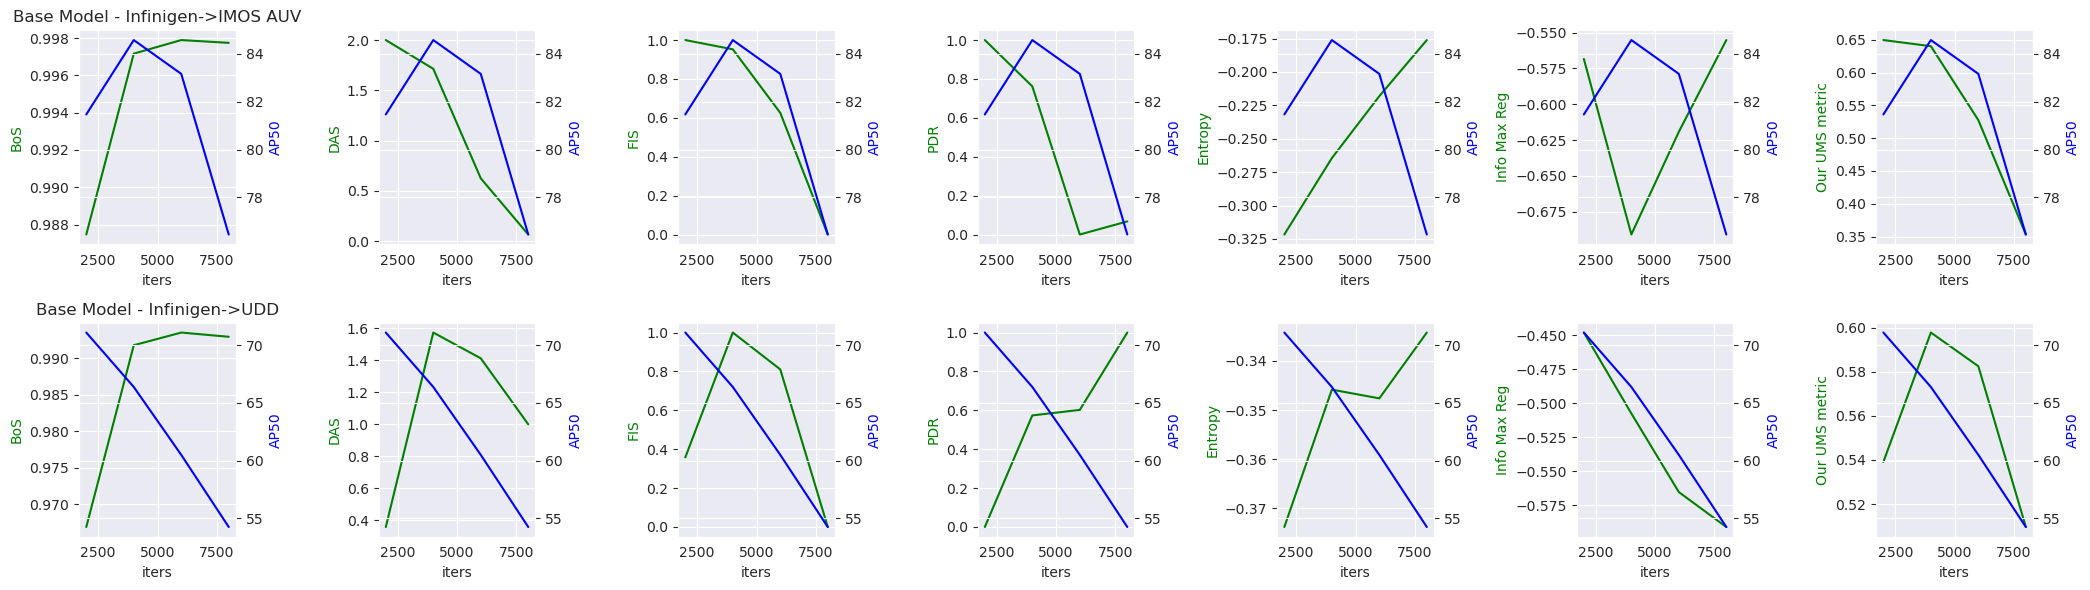

In [67]:
fig, axes = plt.subplots(len(methods), len(vals), figsize=(len(vals)*3, len(methods)*3))

for j, method in enumerate(methods):
    sub_df = df[df['method']==method]#[df['iters'] > 2999]

    # Plot each y variable against the common x variable
    for i, val in enumerate(vals):
        ax = axes[j, i] if len(methods)>1 else axes[i]
        ax.plot(sub_df['iters'], sub_df[val], color='green')
        ax.set_ylabel(y_axis_title(val), color='green')
        ax.set_xlabel('iters')
        ax.grid(True)
        ax2 = ax.twinx()
        ax2.plot(sub_df['iters'], sub_df[baseline], 'b-')
        ax2.set_ylabel(baseline, color='b')
        if i == 0:
            ax.set_title(f"{method_title_dictionary.get(method, method)}")

plt.tight_layout()
plt.show()



## Summary heatmap

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

[0, 3, 6, 2, 1, 4, 5]
[3, 6, 2, 1, 4, 5]
[6, 2, 1, 4, 5]
[2, 1, 4, 5]
[1, 4, 5]
[4, 5]
[5, 6, 2, 1, 0, 4, 3]
[6, 2, 1, 0, 4, 3]
[2, 1, 0, 4, 3]
[1, 0, 4, 3]
[0, 4, 3]


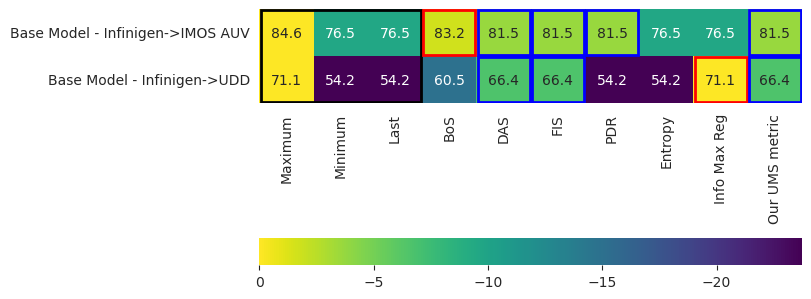

In [95]:

# List of unique methods

df["method_trimmed"] = ['_'.join(m.split('_')[:4]) for m in df["method"]]
comparison = baseline
# Measures to check
rows, rows_annot = [], []
trim_methods = list(set(df["method_trimmed"]))
trim_methods = [m for m in trim_methods if 'strongaug' in m] + [m for m in methods if 'aldi' in m.lower()]

for m in methods:
    row = [m]
    sub_df = df[df["method"]==m]
    max_ap = sub_df[comparison].idxmax()
    max = sub_df[comparison][max_ap]
    row.append(sub_df[comparison][max_ap])
    row.append(0.0)
    min_ap = sub_df[comparison].idxmin()
    row.append((sub_df[comparison][min_ap] - max)/max*100)
    last_ap = sub_df['iters'].idxmax()
    row.append((sub_df[comparison][last_ap] - max)/max*100)
    row_annot = []
    row_annot.append(round(max, 2))
    row_annot.append(round(sub_df[comparison][min_ap], 2))
    row_annot.append(round(sub_df[comparison][last_ap], 2))
    for v in vals:
        max_id = sub_df[v].idxmax()
        row.append((sub_df[comparison][max_id] - max)/max*100 if not np.isnan(max_id) else np.nan)
        row_annot.append(round(sub_df[comparison][max_id] if not np.isnan(max_id) else np.nan, 2))
    rows.append(row)
    rows_annot.append(row_annot)

headings = ['method', f'Max {comparison}','Maximum', 'Minimum', 'Last'] + [y_axis_title(v) for v in vals]
indexes = [f"{row[0]} (Max {comparison} {row[1]:.2f})" for row in rows]
indexes = [f"{method_title_dictionary.get(row[0], row[0])}" for row in rows]
summary_df = pd.DataFrame(data=rows, columns=headings, index=indexes)
annot_df = pd.DataFrame(data=rows_annot)

# Create a heatmap with column headers and a colorbar

cell_width = 1.0
cell_height = 1.0

fig, ax = plt.subplots(figsize=(len(vals) * cell_width, (len(trim_methods) * cell_height) +2.5))
#sns.heatmap(summary_df.iloc[:, 2:], annot=annot_df,  cbar=True, cmap="viridis")
ax = sns.heatmap(summary_df.iloc[:, 2:], ax=ax, annot=annot_df, fmt=".1f",  cbar=True, 
                 cmap="viridis", cbar_kws={"orientation": "horizontal", "pad": 0.5})
#plt.title(f'Best AP50 for different metrics.  The colour indicates the percentage below the maximum AP50.')

cbar = ax.collections[0].colorbar
cbar.ax.invert_xaxis()



# Add a red rectangle around the highest value in each row
col_skip = 3
inset = 0.02
rect = plt.Rectangle((0+inset, 0+inset), 3-2*inset, len(rows_annot)-2*inset, fill=False, edgecolor='black', linewidth=2)
ax.add_patch(rect)
for i, row in enumerate(rows_annot):
    sorted_indices = np.argsort(row[col_skip:])[::-1].tolist()
    print(sorted_indices)
    first_max_j = sorted_indices.pop(0) + col_skip
    print(sorted_indices)
    rect = plt.Rectangle((first_max_j+inset, i+inset), 1-2*inset, 1-2*inset, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    while row[first_max_j] == row[sorted_indices[0] + col_skip]:
        first_max_j = sorted_indices.pop(0) + col_skip
        print(sorted_indices)
        rect = plt.Rectangle((first_max_j+inset, i+inset), 1-2*inset, 1-2*inset, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    second_max_j = sorted_indices.pop(0) + col_skip
    print(sorted_indices)
    rect = plt.Rectangle((second_max_j+inset, i+inset), 1-2*inset, 1-2*inset, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    while len(sorted_indices) > 0 and row[second_max_j] == row[sorted_indices[0] + col_skip]:
        second_max_j = sorted_indices.pop(0) + col_skip
        print(sorted_indices)
        rect = plt.Rectangle((second_max_j+inset, i+inset), 1-2*inset, 1-2*inset, fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)

plt.show()

In [70]:
max = sub_df['BoS_BoS'].max()
np.isnan(max)


np.False_

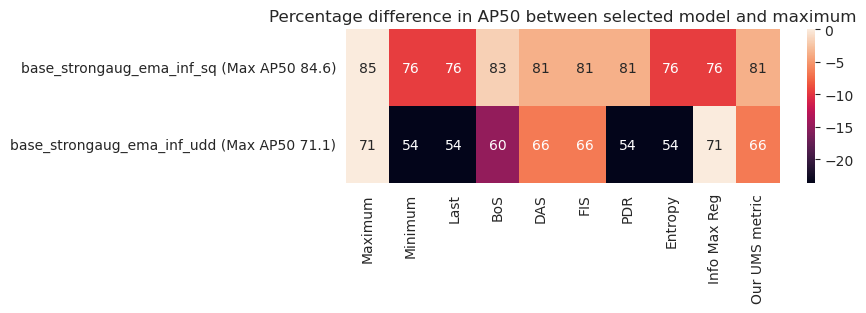

In [71]:
# List of unique methods


comparison = 'AP50'
# Measures to check
rows, rows_annot = [], []
for m in methods:
    row = [m]
    sub_df = df[df["method"]==m]
    max_ap = sub_df['AP50'].idxmax()
    max = sub_df[comparison][max_ap]
    row.append(sub_df[comparison][max_ap])
    row.append(0.0)
    min_ap = sub_df['AP50'].idxmin()
    row.append((sub_df[comparison][min_ap] - max)/max*100)
    last_ap = sub_df['iters'].idxmax()
    row.append((sub_df[comparison][last_ap] - max)/max*100)
    row_annot = []
    row_annot.append(round(max, 2))
    row_annot.append(round(sub_df[comparison][min_ap], 2))
    row_annot.append(round(sub_df[comparison][last_ap], 2))
    for v in vals:
        max_id = sub_df[v].idxmax()
        row.append((sub_df[comparison][max_id] - max)/max*100 if not np.isnan(max_id) else np.nan)
        row_annot.append(round(sub_df[comparison][max_id] if not np.isnan(max_id) else np.nan, 2))
    rows.append(row)
    rows_annot.append(row_annot)

headings = ['method', 'Max AP50','Maximum', 'Minimum', 'Last'] + [y_axis_title(v) for v in vals]
indexes = [f"{row[0]} (Max AP50 {row[1]:.1f})" for row in rows]
summary_df = pd.DataFrame(data=rows, columns=headings, index=indexes)
annot_df = pd.DataFrame(data=rows_annot)


# Create a heatmap with column headers and a colorbar
plt.figure(figsize=(len(vals), len(methods)))
sns.heatmap(summary_df.iloc[:, 2:], annot=annot_df,  cbar=True)
plt.title('Percentage difference in AP50 between selected model and maximum')
plt.show()